<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/llmu/Introduction_Text_Embeddings.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction to Text Embeddings

Text embeddings are a useful way to turn text into numbers that capture its meaning and context. In this notebook, you'll learn how to put them into practice using Cohere's [Embed endpoint](https://docs.cohere.com/reference/embed). You'll calculate embeddings for a dataset of sentences, and plot them in the plane to observe graphically that indeed similar sentences are mapped to close points in the embedding. You'll also explore how to leverage embeddings for semantic search and clustering.

## Setup

We'll start by installing the tools we'll need and then importing them.

In [45]:
! pip install cohere altair -q

In [46]:
import cohere
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [47]:
co = cohere.ClientV2("mez5w4AmTNYRHYA5DBVEAdCuW623OQBSeKGHb57f") # Get your free API key: https://dashboard.cohere.com/api-keys

## Introduction to Text Embeddings

In this section, we understand the intuition behind text embeddings.

### Step 1: Prepare the Dataset

We'll work with a subset of the Airline Travel Information System (ATIS) dataset ([source](https://aclanthology.org/H90-1021/)), created based on customer inquiries related to flight bookings, flight departures, arrivals, delays, and cancellations. In the next code cell, we create and preview a dataframe `df` containing 91 queries.

In [48]:
# Load the dataset to a dataframe
df_orig = pd.read_csv('/content/faq_bbva_title_html_20241028_chunk_5_1.csv')

# Print column names to verify
print(df_orig.columns)

# Take a small sample for illustration purposes
df = df_orig.sample(frac=0.1, random_state=30)

# Reset index
df.reset_index(drop=True, inplace=True)

# Select a specific column to use as 'intents' (adjust 'kb_id' if needed)
if 'kb_id' in df.columns:
    intents = df['kb_id']
    df = df.drop(columns=['kb_id'])
else:
    print("'kb_id' column not found. Please check the actual column names.")

# Display the first few rows
print(df.head())


Index(['Unnamed: 0', 'kb_id', 'source', 'source_id', 'search_content_type',
       'search_content', 'answer_content_type', 'answer_content',
       'creation_date', 'modif_date', 'additional_fields'],
      dtype='object')
   Unnamed: 0 source  source_id search_content_type  \
0        2970    faq      51800               title   
1         524    faq      58360               title   
2        1330    faq     144029               title   
3         827    faq     166781               title   
4         623    faq      60009               title   

                                      search_content answer_content_type  \
0  ¿Cómo emito una transferencia vía Banco de Esp...        title_answer   
1  ¿Cómo anulo el abono de una remesa de cartera ...        title_answer   
2  ¿Cómo consulto el estado de la revisión de doc...        title_answer   
3  ¿Cómo calculo o veo el desglose de las comisio...        title_answer   
4  ¿Cómo anulo o consulto una orden de traspaso d...        title

In [49]:
# Load the dataset to a dataframe
df_orig = pd.read_csv('/content/faq_bbva_title_html_20241028_chunk_5_1.csv')

# Take a small sample for illustration purposes
df = df_orig.sample(frac=0.1, random_state=30)

# Reset index
df.reset_index(drop=True, inplace=True)

# Rename 'search_content' to 'query' for consistency with your original code
df = df.rename(columns={'search_content': 'query'})

# Print the first 10 entries in the 'query' column
for i in df.head(10)["query"]:
    print(i)


¿Cómo emito una transferencia vía Banco de España (OMF)?
¿Cómo anulo el abono de una remesa de cartera o adeudo SEPA financiado?
¿Cómo consulto el estado de la revisión de documentos de un crédito documentario de exportación?
¿Cómo calculo o veo el desglose de las comisiones en las Carteras Multi3strategia de la liquidación del 31/12/20?
¿Cómo anulo o consulto una orden de traspaso de efectivo (OTE)?
¿Cómo asigno un apartado de correos en la correspondencia Postal?
¿Cómo actúo cuando un cliente está dado de alta en la base de datos del banco con distintos documentos de identificación?
¿Cómo doy de alta la comercializadora de un Fondo de Inversión internacional que no aparece al efectuar un traspaso?
¿Cómo el cliente puede consultar la valoración de una cartera de acciones a través de BBVA Empresas (Net Cash)?
¿Cómo consulto los traspasos entre cuentas en divisa (Traspasos Amex)?


### Step 2: Turn Text into Embeddings

Next, we use a function `get_embeddings()` that uses the Embed endpoint to generate the text embeddings.  We store the embeddings in the `query_embeds` column of the dataframe `df`.

In [50]:
# Get text embeddings
def get_embeddings(texts, model="embed-multilingual-v3.0", input_type="search_query", batch_size=96):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        print(f"Processando batch {i//batch_size + 1} di {len(texts)//batch_size + 1}")
        try:
            output = co.embed(
                texts=batch,
                model=model,
                input_type=input_type,
                truncate="END",
                embedding_types=["float"]
            )
            all_embeddings.extend(output.embeddings)
        except Exception as e:
            print(f"Errore durante l'elaborazione del batch {i//batch_size + 1}: {str(e)}")
    return all_embeddings

# Rimuovi eventuali valori nulli o vuoti dalla colonna 'query'
df = df.dropna(subset=['query'])
df = df[df['query'].str.strip() != '']

# Ottieni la lista delle query valide
queries = df['query'].tolist()

print(f"Numero totale di query: {len(queries)}")

# Embed the dataset
embeddings = get_embeddings(queries)

print(f"Numero di embedding generati: {len(embeddings)}")

# Verifica che il numero di embedding corrisponda al numero di righe nel dataframe
if len(embeddings) == len(df):
    df['query_embeds'] = embeddings
    print("Embedding aggiunti con successo al dataframe")
else:
    print(f"Errore: Il numero di embedding ({len(embeddings)}) non corrisponde al numero di righe nel dataframe ({len(df)})")

# Display the first few rows
print(df.head())

Numero totale di query: 301
Processando batch 1 di 4
Processando batch 2 di 4
Processando batch 3 di 4
Processando batch 4 di 4
Numero di embedding generati: 20
Errore: Il numero di embedding (20) non corrisponde al numero di righe nel dataframe (301)
   Unnamed: 0  kb_id source  source_id search_content_type  \
0        2970   2971    faq      51800               title   
1         524    525    faq      58360               title   
2        1330   1331    faq     144029               title   
3         827    828    faq     166781               title   
4         623    624    faq      60009               title   

                                               query answer_content_type  \
0  ¿Cómo emito una transferencia vía Banco de Esp...        title_answer   
1  ¿Cómo anulo el abono de una remesa de cartera ...        title_answer   
2  ¿Cómo consulto el estado de la revisión de doc...        title_answer   
3  ¿Cómo calculo o veo el desglose de las comisio...        title_answe

### Step 3: Visualize Embeddings on a Heatmap

Let’s get some visual intuition about the embeddings by plotting these numbers on a heatmap. What we can do is compress the dimension to a much lower number, say 10. We can do this via a technique called [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis), which reduces the number of dimensions in an embedding while retaining as much information as possible.

In [52]:
import cohere
import time
import numpy as np
import pandas as pd
import json  # Assicurati che questa riga sia presente all'inizio del file

co = cohere.ClientV2("mez5w4AmTNYRHYA5DBVEAdCuW623OQBSeKGHb57f")  # Sostituisci con la tua chiave API

def is_valid_query(query):
    return isinstance(query, str) and len(query.strip()) > 0

def get_embeddings(texts, batch_size=20, max_retries=3):
    all_embeddings = []
    valid_indices = []

    for i, text in enumerate(texts):
        if is_valid_query(text):
            valid_indices.append(i)

    for i in range(0, len(valid_indices), batch_size):
        batch_indices = valid_indices[i:i+batch_size]
        batch = [texts[j] for j in batch_indices]
        print(f"Processando batch {i//batch_size + 1} di {len(valid_indices)//batch_size + 1}")

        for attempt in range(max_retries):
            try:
                output = co.embed(
                    texts=batch,
                    model="embed-multilingual-v3.0",
                    input_type="search_query",
                    embedding_types=["float"]
                )

                # Salva gli embedding individualmente
                for idx, embed in zip(batch_indices, output.embeddings):
                    embed_list = list(embed)
                    all_embeddings.append(embed_list)

                    # Stampa informazioni sull'embedding
                    print(f"Embedding {idx}: lunghezza = {len(embed_list)}, primi 5 valori = {embed_list[:5]}")

                    # Salva l'embedding individuale in un file JSON
                    with open(f'embedding_{idx}.json', 'w') as f:
                        json.dump({'index': idx, 'embedding': embed_list}, f)

                print(f"Batch {i//batch_size + 1} processato con successo. Totale embedding: {len(all_embeddings)}")
                break
            except Exception as e:
                print(f"Errore nel batch {i//batch_size + 1}, tentativo {attempt + 1}: {str(e)}")
                if attempt == max_retries - 1:
                    print(f"Impossibile processare il batch {i//batch_size + 1} dopo {max_retries} tentativi.")
                else:
                    time.sleep(5)  # Attendi 5 secondi prima di riprovare

    return all_embeddings, valid_indices[:len(all_embeddings)]



Next, we visualize the embeddings of the first 9 data points.

Embedding 0: tipo = <class 'list'>, lunghezza = 2
    Contenuto: ['float_', [[-0.0009889603, 0.03213501, 0.019042969, 0.02796936, -0.013366699, 0.015930176, 0.00178051, -0.039855957, -0.024093628, 0.004722595, 0.06304932, -0.02027893, 0.009468079, -0.029541016, 0.006011963, -0.0060157776, -0.016418457, 0.015090942, -0.012825012, -0.012580872, 0.011459351, 0.018630981, 0.0078048706, 0.041381836, 0.0037555695, -0.025039673, 0.01777649, 0.019348145, 0.028793335, 0.033813477, 0.007865906, -0.019088745, 0.06842041, 0.02432251, 0.039031982, 0.038482666, -0.01802063, -0.017059326, -0.0033950806, 0.06085205, 0.004234314, -0.015434265, -0.016784668, -0.0029754639, -0.0055732727, 0.024612427, 0.0010089874, -0.026275635, 0.06970215, 0.041992188, -0.021148682, 0.0135650635, 0.023956299, -0.013015747, 0.014892578, -0.023742676, 0.0035114288, -0.028274536, -0.059783936, -0.052337646, 0.004184723, -0.012496948, -0.052337646, 0.05529785, -0.011413574, -0.01209259, 0.017654419, -0.06896973, 0.003787994

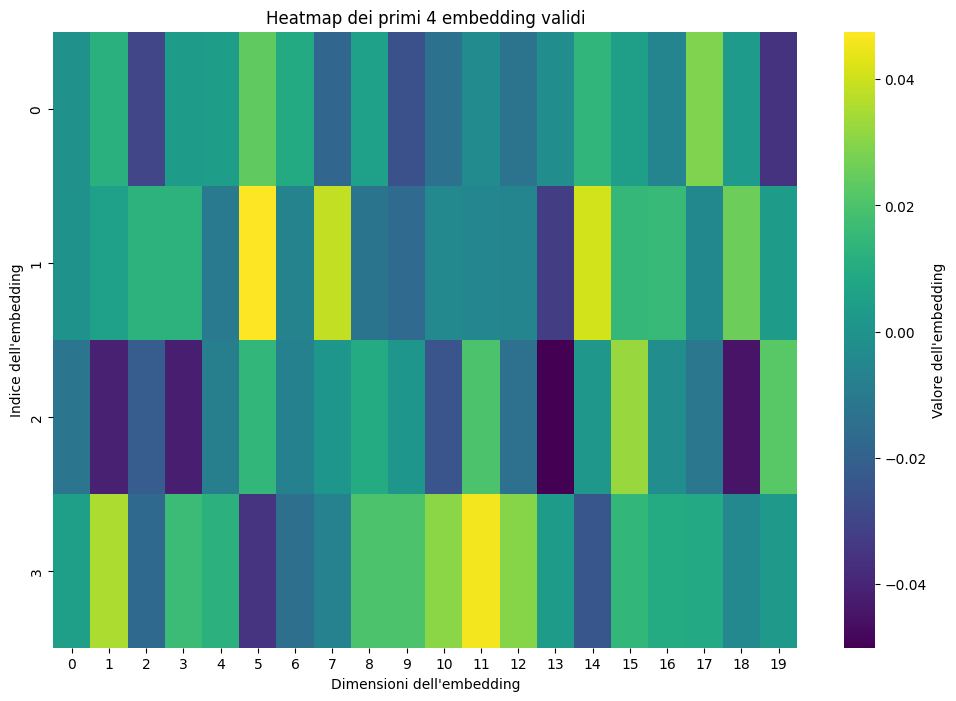

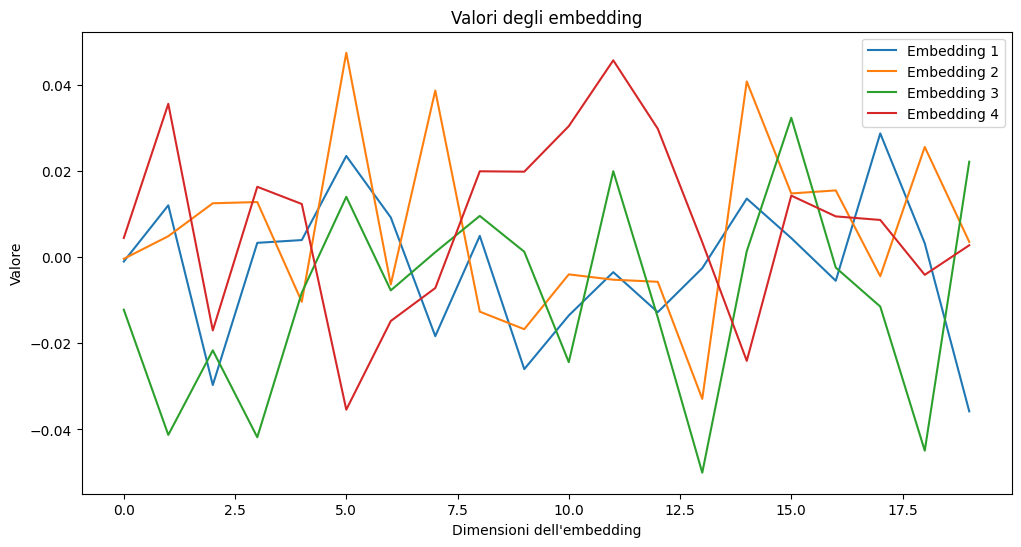

Statistiche degli embedding:
        mean       std       min       max
0  -0.002258  0.006106 -0.012177  0.004490
1   0.002837  0.027885 -0.041260  0.035645
2  -0.013939  0.015948 -0.029678  0.012543
3  -0.002315  0.023293 -0.041809  0.016373
4  -0.000547  0.009252 -0.010338  0.012375
5   0.012421  0.030185 -0.035400  0.047516
6  -0.004890  0.008776 -0.014809  0.009247
7   0.003608  0.021424 -0.018326  0.038727
8   0.005477  0.011784 -0.012634  0.019974
9  -0.005382  0.017575 -0.025986  0.019882
10 -0.002853  0.020540 -0.024368  0.030457
11  0.014266  0.020720 -0.005211  0.045746
12 -0.000644  0.017894 -0.013985  0.029861
13 -0.020500  0.021936 -0.050049  0.003485
14  0.007951  0.023351 -0.024063  0.040833
15  0.016502  0.010072  0.004456  0.032410
16  0.004292  0.008564 -0.005459  0.015533
17  0.005400  0.015306 -0.011452  0.028778
18 -0.005035  0.025496 -0.044922  0.025620
19 -0.001807  0.021106 -0.035797  0.022202


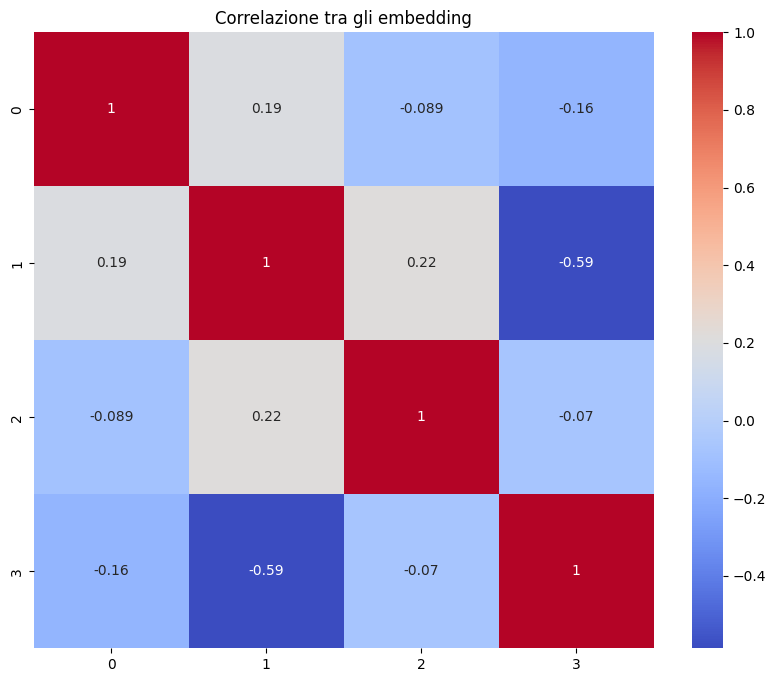

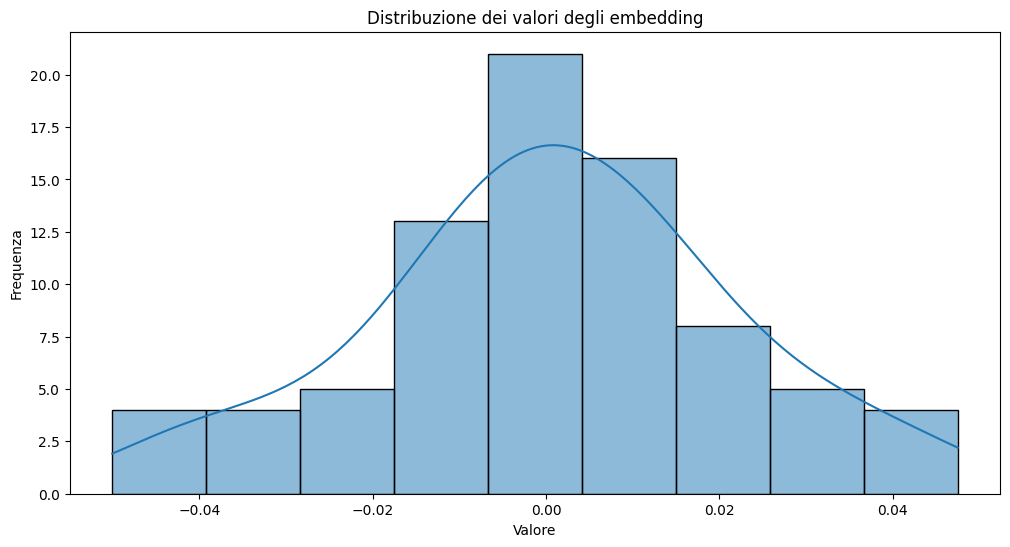

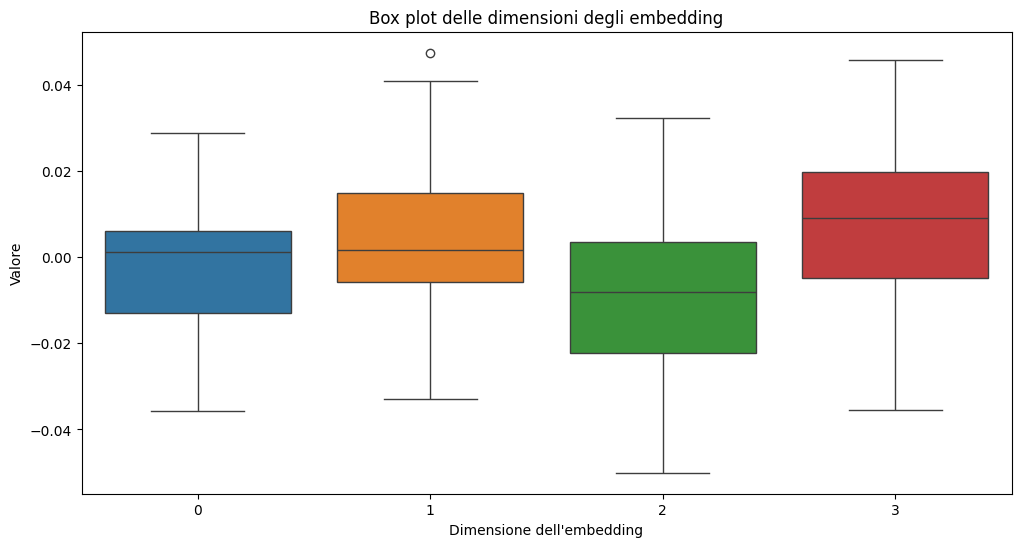

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per estrarre i valori float dagli embedding
def extract_float_values(embed):
    if isinstance(embed, list) and len(embed) == 2:
        if embed[0] == 'float_' and isinstance(embed[1], list):
            return np.array(embed[1])
    return np.array([])

# Esaminiamo la struttura degli embedding
valid_embeddings = []
for i, embed in enumerate(df['query_embeds'].head(20)):  # Aumentato a 20 per provare a ottenere più embedding
    print(f"Embedding {i}: tipo = {type(embed)}, lunghezza = {len(embed) if isinstance(embed, list) else 'N/A'}")
    print(f"    Contenuto: {embed}")
    float_values = extract_float_values(embed)
    if float_values.size > 0:
        valid_embeddings.append(float_values)
        print(f"    Valori float estratti: shape = {float_values.shape}")
    else:
        print("    Nessun valore float estratto.")
    print()

# Se non abbiamo embedding validi, non possiamo creare le visualizzazioni
if not valid_embeddings:
    print("Non ci sono embedding validi da visualizzare.")
else:
    # Convertiamo la lista di array in un unico array 3D
    embedding_array = np.array(valid_embeddings)

    print(f"Forma dell'array di embedding: {embedding_array.shape}")

    # Se abbiamo un array 3D, prendiamo solo il primo "canale"
    if embedding_array.ndim == 3:
        embedding_array = embedding_array[:, :, 0]

    print(f"Forma dell'array di embedding visualizzato: {embedding_array.shape}")

    # 1. Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(embedding_array, cmap='viridis', cbar_kws={'label': 'Valore dell\'embedding'})
    plt.title(f'Heatmap dei primi {len(valid_embeddings)} embedding validi')
    plt.xlabel('Dimensioni dell\'embedding')
    plt.ylabel('Indice dell\'embedding')
    plt.show()

    # 2. Grafico a linee
    plt.figure(figsize=(12, 6))
    for i, embed in enumerate(embedding_array):
        plt.plot(embed, label=f'Embedding {i+1}')
    plt.title('Valori degli embedding')
    plt.xlabel('Dimensioni dell\'embedding')
    plt.ylabel('Valore')
    plt.legend()
    plt.show()

    # 3. Analisi statistica
    stats = pd.DataFrame({
        'mean': np.mean(embedding_array, axis=0),
        'std': np.std(embedding_array, axis=0),
        'min': np.min(embedding_array, axis=0),
        'max': np.max(embedding_array, axis=0)
    })
    print("Statistiche degli embedding:")
    print(stats)

    # 4. Correlazione tra embedding
    if embedding_array.shape[0] > 2:
        corr = np.corrcoef(embedding_array)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlazione tra gli embedding')
        plt.show()
    else:
        print("Non ci sono abbastanza embedding per calcolare la correlazione.")

    # 5. Distribuzione dei valori degli embedding
    plt.figure(figsize=(12, 6))
    sns.histplot(embedding_array.flatten(), kde=True)
    plt.title('Distribuzione dei valori degli embedding')
    plt.xlabel('Valore')
    plt.ylabel('Frequenza')
    plt.show()

    # 6. Box plot delle dimensioni degli embedding
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=embedding_array.T)
    plt.title('Box plot delle dimensioni degli embedding')
    plt.xlabel('Dimensione dell\'embedding')
    plt.ylabel('Valore')
    plt.show()


Notice the 3 inquiries about ground transportation in Boston - their embeddings patterns are very similar, and at the same time are distinctive from the rest.

### Step 4: Visualize Embeddings on a 2D Plot

We can investigate this further by compressing the embeddings to two dimensions and plotting them on a scatter plot. What we would expect is that texts of similar meaning would be closer to each other, and vice versa.

In [58]:
import pandas as pd

# Mostra le colonne del DataFrame
print("Colonne del DataFrame:")
print(df.columns)

# Mostra le prime righe del DataFrame
print("\nPrime righe del DataFrame:")
print(df.head())

# Cerca colonne che potrebbero contenere gli embedding
for col in df.columns:
    sample = df[col].iloc[0]
    print(f"\nColonna: {col}")
    print(f"Tipo: {type(sample)}")
    print(f"Valore: {sample}")

# Se c'è una colonna 'query', mostriamone alcuni esempi
if 'query' in df.columns:
    print("\nEsempi di query:")
    print(df['query'].head())


Colonne del DataFrame:
Index(['Unnamed: 0', 'kb_id', 'source', 'source_id', 'search_content_type',
       'query', 'answer_content_type', 'answer_content', 'creation_date',
       'modif_date', 'additional_fields'],
      dtype='object')

Prime righe del DataFrame:
   Unnamed: 0  kb_id source  source_id search_content_type  \
0        2970   2971    faq      51800               title   
1         524    525    faq      58360               title   
2        1330   1331    faq     144029               title   
3         827    828    faq     166781               title   
4         623    624    faq      60009               title   

                                               query answer_content_type  \
0  ¿Cómo emito una transferencia vía Banco de Esp...        title_answer   
1  ¿Cómo anulo el abono de una remesa de cartera ...        title_answer   
2  ¿Cómo consulto el estado de la revisión de doc...        title_answer   
3  ¿Cómo calculo o veo el desglose de las comisio...     

In [60]:
!pip install sentence-transformers altair


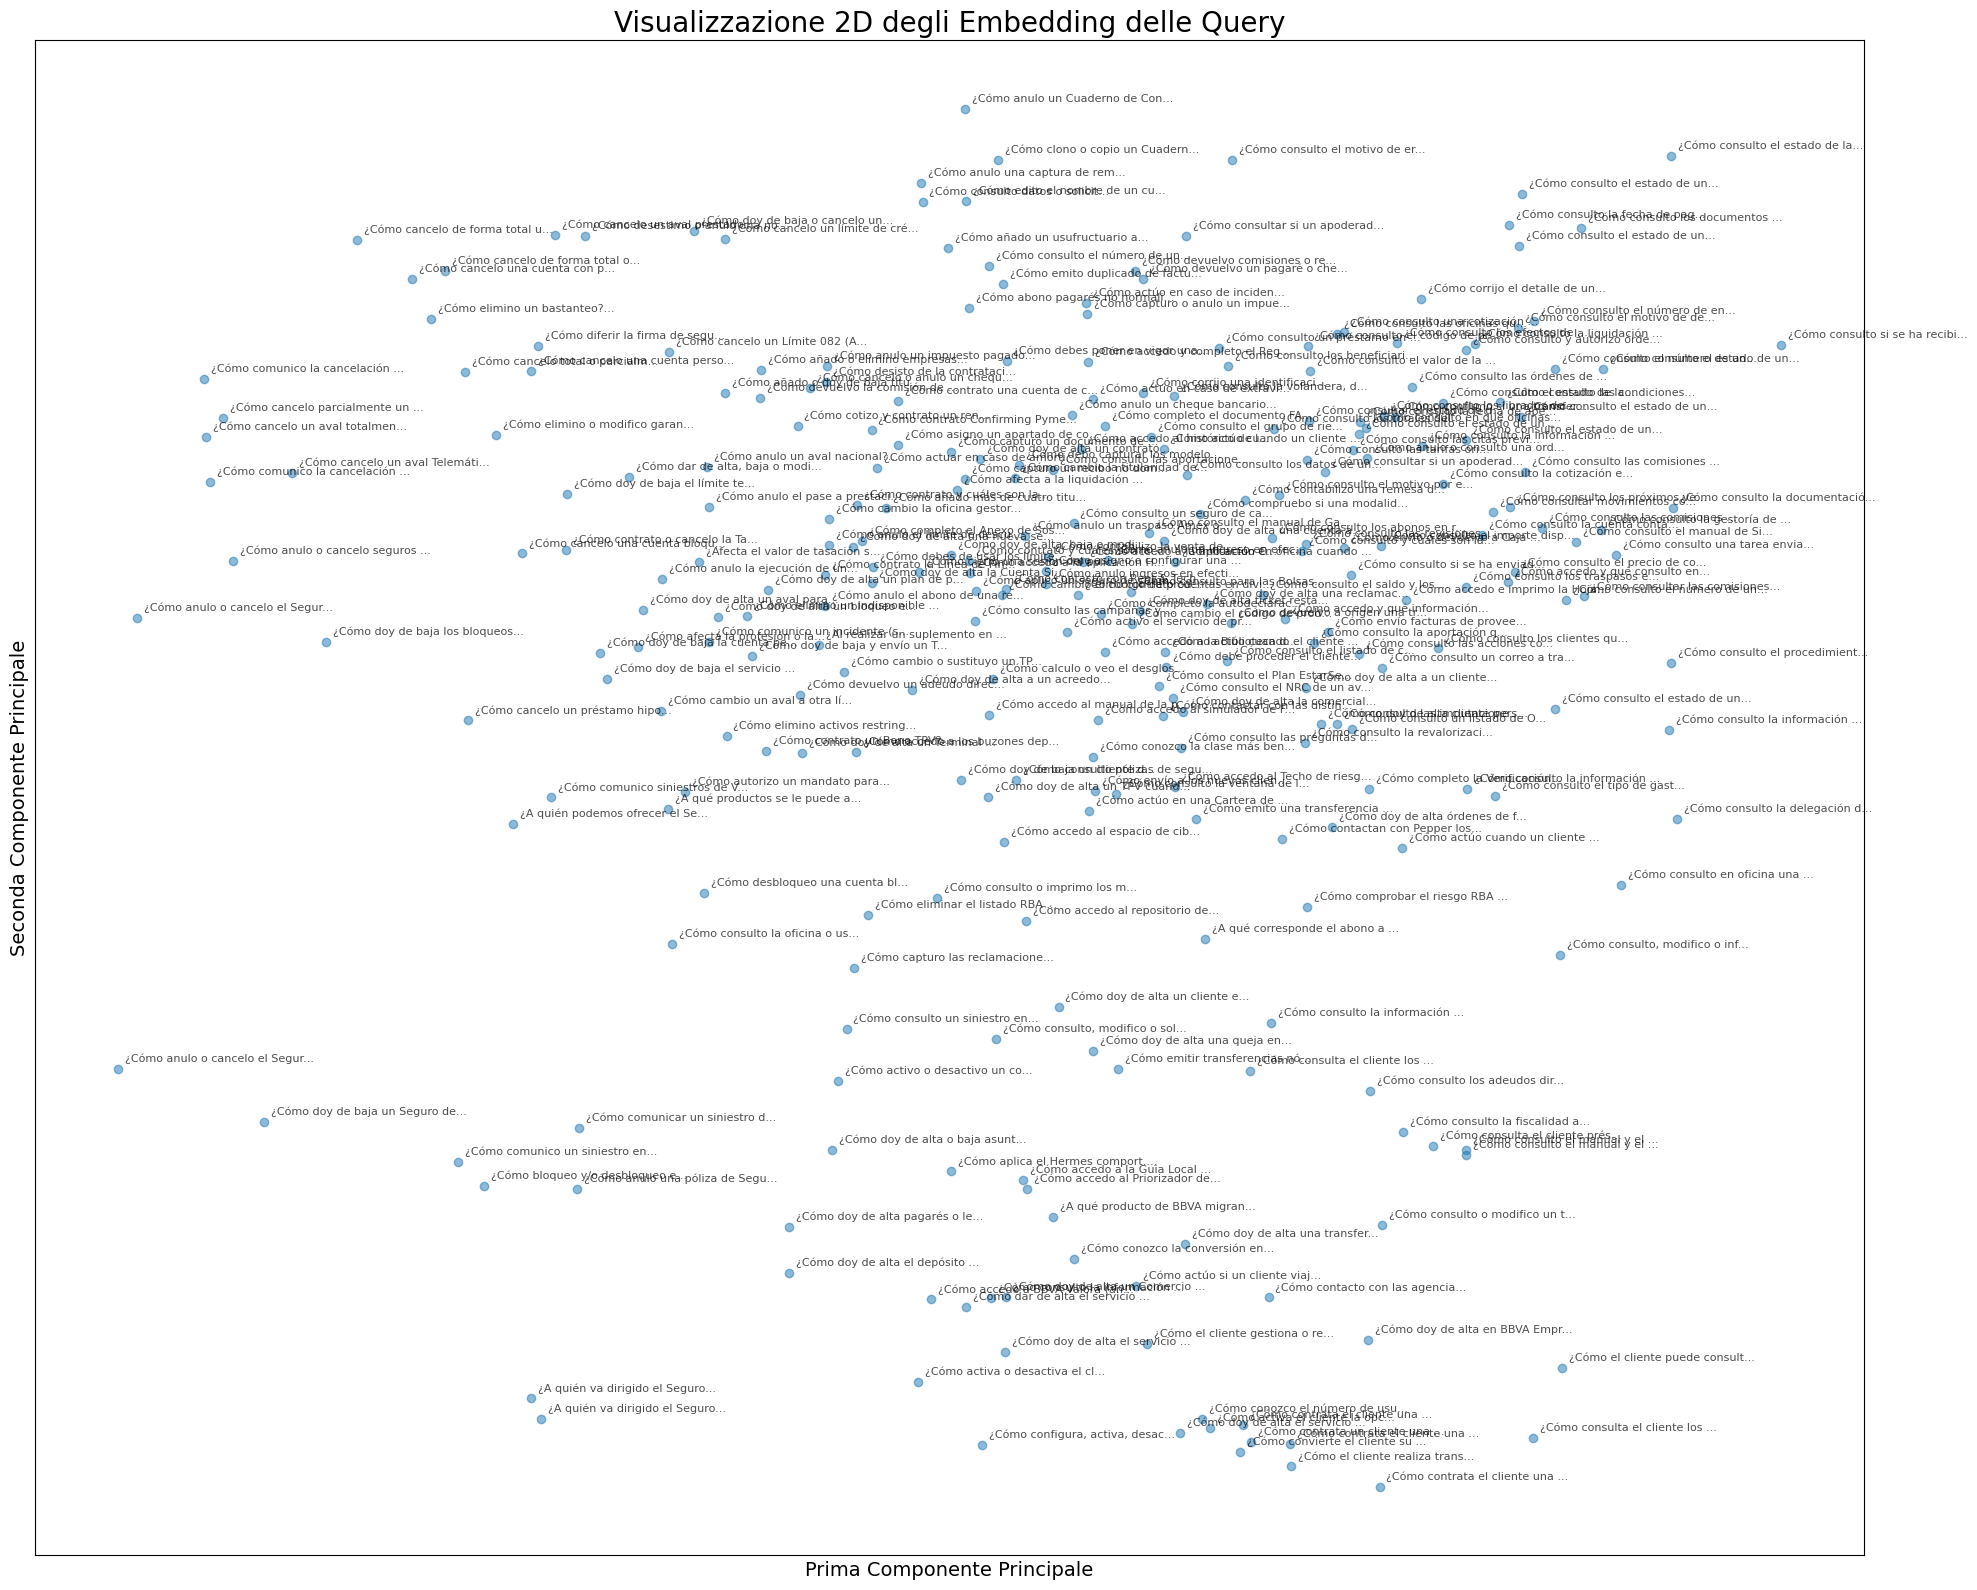

<Figure size 640x480 with 0 Axes>

In [64]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Carica il modello di Sentence-Transformers (questo potrebbe richiedere un po' di tempo)
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Genera gli embedding per le query
queries = df['query'].tolist()
embeddings = model.encode(queries)

# Applica PCA per ridurre la dimensionalità a 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Crea il grafico
plt.figure(figsize=(20, 16))  # Aumenta la dimensione del grafico
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Annota i punti con le query (prime 30 caratteri)
for i, txt in enumerate(queries):
    plt.annotate(txt[:30] + '...',
                 (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 fontsize=8,
                 alpha=0.7,
                 xytext=(5, 5),
                 textcoords='offset points')

plt.title('Visualizzazione 2D degli Embedding delle Query', fontsize=20)
plt.xlabel('Prima Componente Principale', fontsize=14)
plt.ylabel('Seconda Componente Principale', fontsize=14)

# Rimuovi i tick dagli assi per un aspetto più pulito
plt.xticks([])
plt.yticks([])

# Aggiungi una griglia leggera
plt.grid(True, linestyle='--', alpha=0.3)

# Aggiungi un bordo al grafico
plt.box(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

# Salva il grafico come immagine
plt.savefig('query_embeddings_visualization.png', dpi=300, bbox_inches='tight')


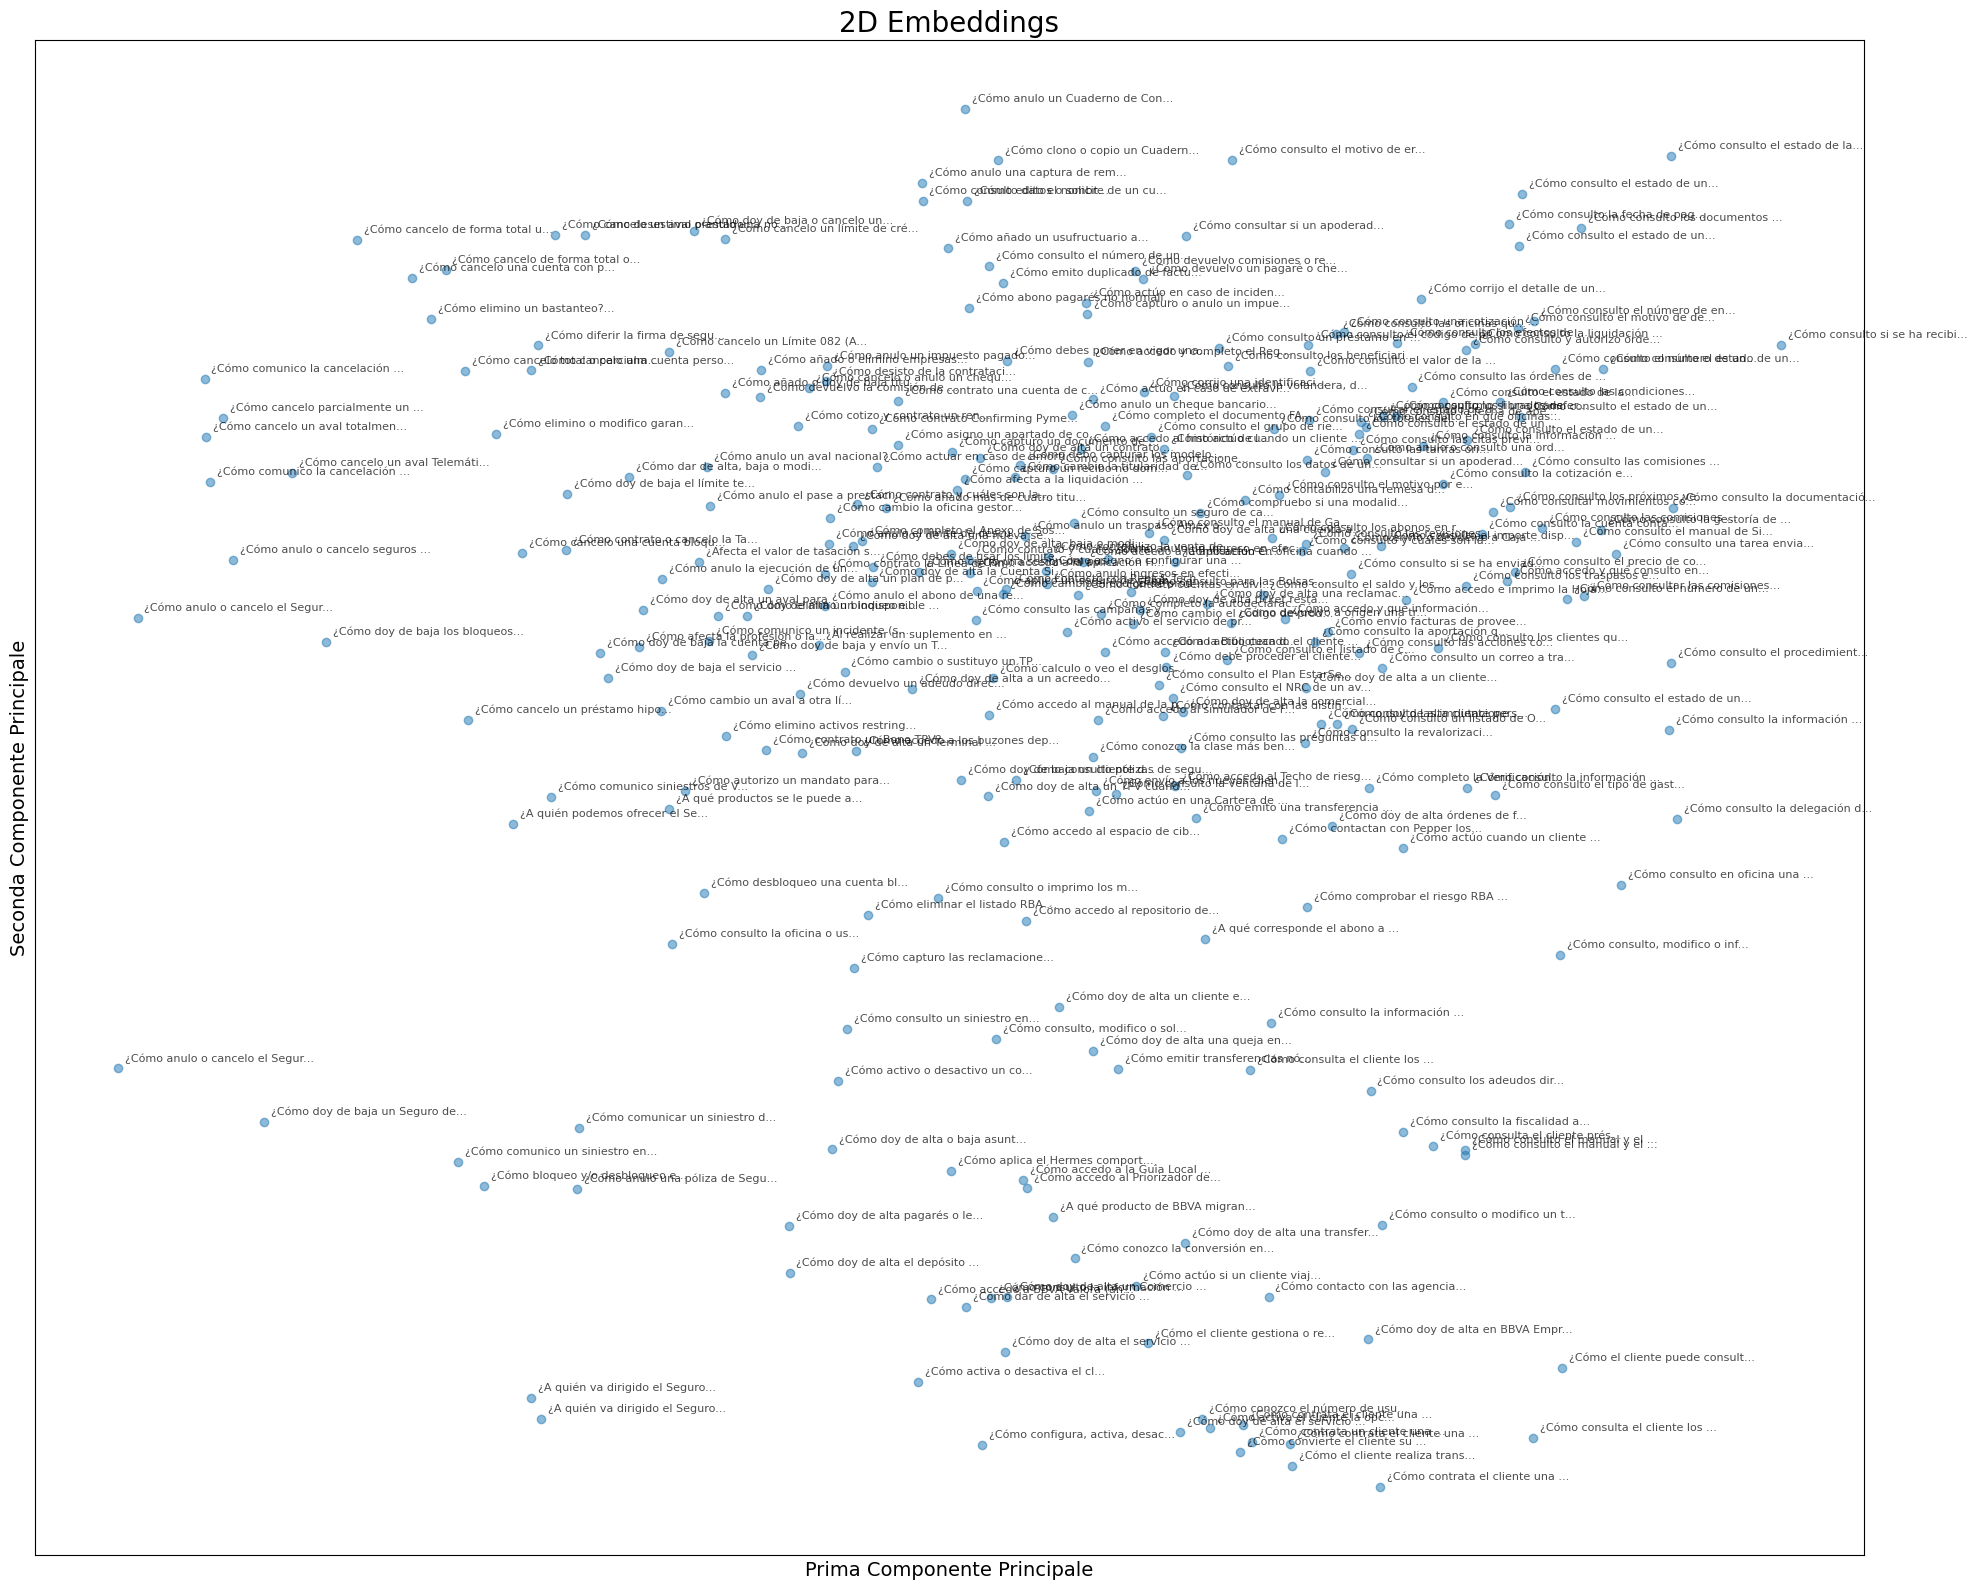

<Figure size 640x480 with 0 Axes>

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Funzione per ottenere le componenti principali
def get_pc(arr, n):
    pca = PCA(n_components=n)
    return pca.fit_transform(arr)

# Assumiamo che 'embeddings' sia il tuo array di embedding
# Se non hai ancora generato gli embedding, dovresti farlo prima di questo passo

# Riduci gli embedding a 2 componenti principali
embeds_pc2 = get_pc(embeddings, 2)

# Aggiungi le componenti principali al dataframe
df_pc2 = pd.concat([df, pd.DataFrame(embeds_pc2, columns=['PC1', 'PC2'])], axis=1)

# Crea il grafico
plt.figure(figsize=(20, 16))
plt.scatter(df_pc2['PC1'], df_pc2['PC2'], alpha=0.5)
plt.title('2D Embeddings', fontsize=20)
plt.xlabel('Prima Componente Principale', fontsize=14)
plt.ylabel('Seconda Componente Principale', fontsize=14)

# Annota i punti con le query (prime 30 caratteri)
for i, txt in enumerate(df_pc2['query']):
    plt.annotate(txt[:30] + '...',
                 (df_pc2['PC1'].iloc[i], df_pc2['PC2'].iloc[i]),
                 fontsize=8,
                 alpha=0.7,
                 xytext=(5, 5),
                 textcoords='offset points')

# Rimuovi i tick dagli assi per un aspetto più pulito
plt.xticks([])
plt.yticks([])

# Aggiungi una griglia leggera
plt.grid(True, linestyle='--', alpha=0.3)

# Aggiungi un bordo al grafico
plt.box(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

# Salva il grafico come immagine
plt.savefig('query_embeddings_visualization.png', dpi=300, bbox_inches='tight')


Here texts of similar meaning are located close together. We see inquiries about tickets on the left, inquiries about airlines somewhere around the middle, and inquiries about ground transportation on the top right.

## Introduction to Semantic Search

In this section, you'll learn how to use embeddings to build a search capability that surfaces relevant information based on the semantic meaning of a query. We'll work with the same 9 data points plotted above.

_Read the accompanying [blog post here](https://txt.cohere.ai/introduction-to-semantic-search/)._

### Step 1: Embed the Search Query

We'll use the query below that inquires about ground transportation without using the words "ground transportation" explicitly. Ideally, the corresponding data points that are surfaced as most relevant are the three dealing with ground transportation options.

In [68]:
# Define new query
new_query = "Come posso effettuare un trasferimento di denaro urgente a un altro conto?"


We embed the query using the same `get_embeddings()` function as before, but now we set `input_type="search_query"` because we're embedding a search query that we want to compare to the embedded documents.

In [69]:
from sentence_transformers import SentenceTransformer

# Assicurati che il modello sia già caricato
# Se non l'hai fatto prima, decommentare la riga seguente:
# model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Define new query
new_query = "Come posso effettuare un trasferimento di denaro urgente a un altro conto?"

# Get embeddings of the new query
new_query_embeds = model.encode([new_query])[0]

print("Dimensione dell'embedding della nuova query:", new_query_embeds.shape)


Dimensione dell'embedding della nuova query: (512,)


In [70]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assicurati che 'embeddings' contenga gli embedding di tutte le query nel tuo dataset
# Se non l'hai già fatto, puoi generarli così:
# embeddings = model.encode(df['query'].tolist())

# Calcola la similarità del coseno tra la nuova query e tutte le query esistenti
similarities = cosine_similarity([new_query_embeds], embeddings)[0]

# Trova gli indici delle 5 query più simili
top_5_indices = np.argsort(similarities)[-5:][::-1]

print("Le 5 query più simili sono:")
for i, idx in enumerate(top_5_indices, 1):
    print(f"{i}. (Similarità: {similarities[idx]:.4f}) {df['query'].iloc[idx]}")


Le 5 query più simili sono:
1. (Similarità: 0.6612) ¿Cómo emito una transferencia vía Banco de España (OMF)?
2. (Similarità: 0.6191) ¿Cómo anulo un cheque bancario?
3. (Similarità: 0.6069) ¿Cómo envío facturas de proveedores del banco a contabilizar?
4. (Similarità: 0.6029) ¿Cómo consultar las comisiones por emisión de transferencia nacional de una cuenta personal?
5. (Similarità: 0.6008) ¿Cómo contabilizo una remesa de efectivo enviada o recibida desde Caja Central?


### Step 2: Compare to Embedded Documents

We define and use a function `get_similarity()` that employs cosine similarity to determine how similar the documents are to our query.

In [72]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(target, candidates):
    # Assicuriamoci che target sia un array 2D
    target = np.array(target).reshape(1, -1)
    candidates = np.array(candidates)

    # Calcola la similarità del coseno
    sim = cosine_similarity(target, candidates)
    sim = np.squeeze(sim)

    # Ordina gli indici in base alla similarità (dal più alto al più basso)
    sort_index = np.argsort(sim)[::-1]
    sort_score = sim[sort_index]

    # Restituisci una lista di tuple (indice, punteggio)
    return list(zip(sort_index, sort_score))

# Usa la funzione per ottenere la similarità tra la nuova query e tutte le query esistenti
similarity = get_similarity(new_query_embeds, embeddings)

# Stampa i top 5 risultati
print("Le 5 query più simili sono:")
for i, (idx, score) in enumerate(similarity[:5], 1):
    print(f"{i}. (Similarità: {score:.4f}) {df['query'].iloc[idx]}")
# Assumiamo che 'category' sia una colonna nel tuo DataFrame
print("Le 5 query più simili con le loro categorie:")
for i, (idx, score) in enumerate(similarity[:5], 1):
    query = df['query'].iloc[idx]
    category = df['category'].iloc[idx] if 'category' in df.columns else 'N/A'
    print(f"{i}. (Similarità: {score:.4f}) [{category}] {query}")



Le 5 query più simili sono:
1. (Similarità: 0.6612) ¿Cómo emito una transferencia vía Banco de España (OMF)?
2. (Similarità: 0.6191) ¿Cómo anulo un cheque bancario?
3. (Similarità: 0.6069) ¿Cómo envío facturas de proveedores del banco a contabilizar?
4. (Similarità: 0.6029) ¿Cómo consultar las comisiones por emisión de transferencia nacional de una cuenta personal?
5. (Similarità: 0.6008) ¿Cómo contabilizo una remesa de efectivo enviada o recibida desde Caja Central?
Le 5 query più simili con le loro categorie:
1. (Similarità: 0.6612) [N/A] ¿Cómo emito una transferencia vía Banco de España (OMF)?
2. (Similarità: 0.6191) [N/A] ¿Cómo anulo un cheque bancario?
3. (Similarità: 0.6069) [N/A] ¿Cómo envío facturas de proveedores del banco a contabilizar?
4. (Similarità: 0.6029) [N/A] ¿Cómo consultar las comisiones por emisión de transferencia nacional de una cuenta personal?
5. (Similarità: 0.6008) [N/A] ¿Cómo contabilizo una remesa de efectivo enviada o recibida desde Caja Central?


We'll then view the documents in decreasing order of similarity.

In [73]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assicuriamoci di avere la nuova query e i suoi embedding
new_query = "Come posso effettuare un trasferimento di denaro urgente a un altro conto?"
new_query_embeds = model.encode([new_query])[0]

# Funzione per calcolare la similarità
def get_similarity(target, candidates):
    target = np.array(target).reshape(1, -1)
    candidates = np.array(candidates)
    sim = cosine_similarity(target, candidates)
    sim = np.squeeze(sim)
    sort_index = np.argsort(sim)[::-1]
    sort_score = sim[sort_index]
    return list(zip(sort_index, sort_score))

# Calcola la similarità
similarity = get_similarity(new_query_embeds, embeddings)

# Visualizza i risultati
print('Query:')
print(new_query, '\n')

print('Most Similar Documents:')
for idx, sim in similarity[:5]:  # Mostriamo solo i top 5 risultati
    print(f'Similarity: {sim:.2f};', df.iloc[idx]['query'])


Query:
Come posso effettuare un trasferimento di denaro urgente a un altro conto? 

Most Similar Documents:
Similarity: 0.66; ¿Cómo emito una transferencia vía Banco de España (OMF)?
Similarity: 0.62; ¿Cómo anulo un cheque bancario?
Similarity: 0.61; ¿Cómo envío facturas de proveedores del banco a contabilizar?
Similarity: 0.60; ¿Cómo consultar las comisiones por emisión de transferencia nacional de una cuenta personal?
Similarity: 0.60; ¿Cómo contabilizo una remesa de efectivo enviada o recibida desde Caja Central?


The top three most similar documents are the inquiries about ground transportation. Notice that the query didn't explicitly mention "ground transportation," yet the embedding successfully captured the underlying meaning. It recognized the words "taxi" and "bus," grouping them together as similar concepts.

### Step 3: Visualize the Results in a 2D Plot

To prepare for plotting, we use PCA to reduce the query embedding to 2 dimensions with the `get_pc()` function we defined earlier.

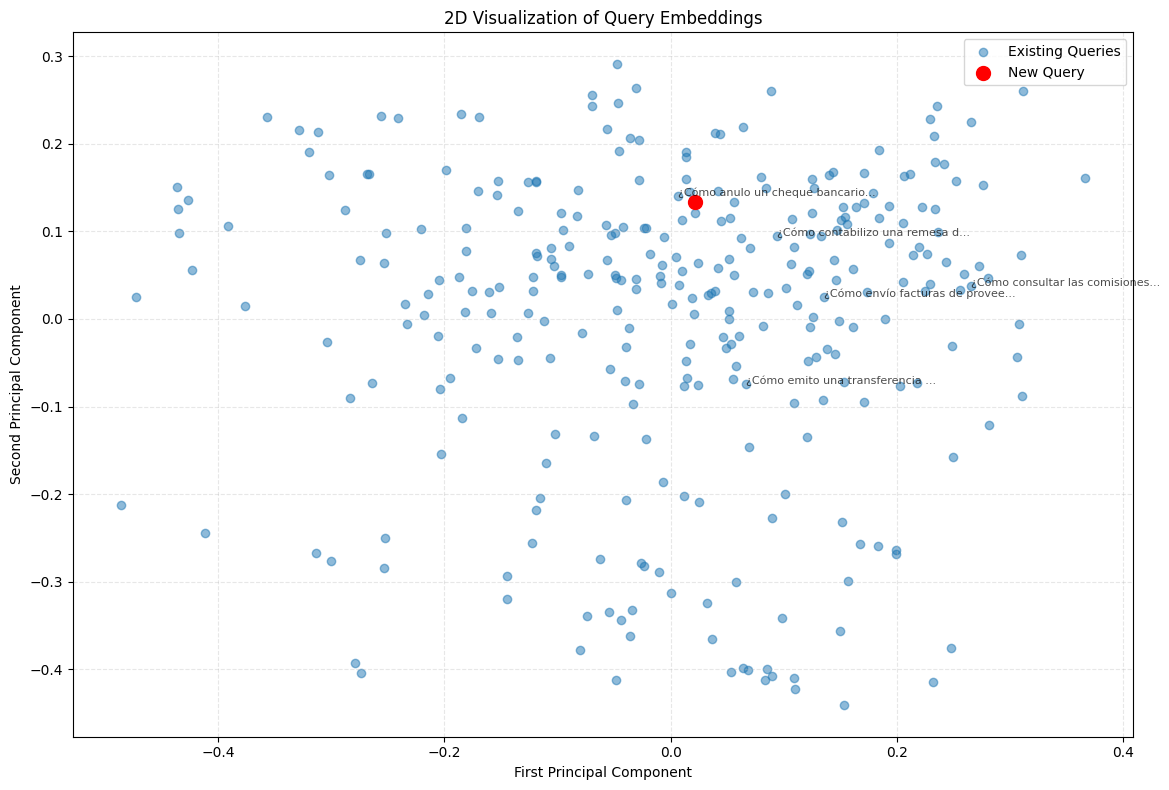

In [75]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Funzione per ottenere le componenti principali
def get_pc(arr, n):
    pca = PCA(n_components=n)
    return pca.fit_transform(arr)

# Assicuriamoci che gli embedding siano disponibili
# Se non li hai già, generali di nuovo
if 'embeddings' not in locals():
    embeddings = model.encode(df['query'].tolist())

# Crea un nuovo dataframe
df_sem = df[['query']].copy()

# Aggiungi la nuova query
new_row = pd.DataFrame({'query': [new_query]})
df_sem = pd.concat([df_sem, new_row], ignore_index=True)

# Combina gli embedding esistenti con l'embedding della nuova query
all_embeddings = np.vstack([embeddings, new_query_embeds])

# Riduci la dimensione degli embedding a 2
embeds_sem_pc2 = get_pc(all_embeddings, 2)

# Aggiungi le componenti principali al dataframe
df_sem_pc2 = pd.concat([df_sem, pd.DataFrame(embeds_sem_pc2, columns=['PC1', 'PC2'])], axis=1)

# Visualizza il risultato
plt.figure(figsize=(12, 8))
plt.scatter(df_sem_pc2['PC1'][:-1], df_sem_pc2['PC2'][:-1], alpha=0.5, label='Existing Queries')
plt.scatter(df_sem_pc2['PC1'].iloc[-1], df_sem_pc2['PC2'].iloc[-1], color='red', s=100, label='New Query')

# Annota i punti più vicini
similarity_scores = get_similarity(new_query_embeds, embeddings)
for idx, score in similarity_scores[:5]:
    plt.annotate(df_sem['query'].iloc[idx][:30] + '...',
                 (df_sem_pc2['PC1'].iloc[idx], df_sem_pc2['PC2'].iloc[idx]),
                 fontsize=8, alpha=0.7)

plt.title('2D Visualization of Query Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


We then can plot the query on a 2D scatter plot with the nine documents.

In [ ]:
# Create column for representing chart legend
df_sem_pc2['Source'] = 'Existing'
df_sem_pc2.at[len(df_sem_pc2)-1, 'Source'] = "New"

# Plot on a chart
df_sem_pc2.columns = df_sem_pc2.columns.astype(str)
selection = list(range(sample)) + [-1]
generate_chart(df_sem_pc2.iloc[selection],'0','1',color='Source',title='Semantic Search')

alt.LayerChart(...)

We see that the query is located closest to the FAQs about ground transportation.

## Clustering Using Embeddings

In this section, you will learn how to use embeddings to group similar documents into clusters, to discover emerging patterns in the documents. We'll work with the same 9 data points as before.

_Read the accompanying [blog post here](https://docs.cohere.com/docs/clustering-with-embeddings)._

### Step 1: Embed the Text for Clustering

We embed the documents using the same `get_embeddings()` function as before, but now we set `input_type="clustering"` because we'll use the embeddings for clustering.

In [ ]:
# Embed the text for clustering
df['clustering_embeds'] = get_embeddings(df['query'].tolist(), input_type="clustering")
embeds = np.array(df['clustering_embeds'].tolist())

### Step 2: Cluster the Embeddings

We use the K-means algorithms to cluster these data points. Since our dataset is small, we'll set the number of clusters to 2. In actual applications, this number is normally larger.

We store the cluster assignments in the `"cluster"` column of the `df_clust` DataFrame.

In [ ]:
# Pick the number of clusters
n_clusters = 2

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
classes = kmeans_model.fit_predict(embeds).tolist()

# Store the cluster assignments
df_clust = df_pc2.copy()
df_clust['cluster'] = (list(map(str,classes)))

# Preview the cluster assignments
df_clust.head()

,query,query_embeds,0,1,cluster
0,which airlines fly from boston to washington ...,"[0.02609253, 0.012168884, -0.008903503, 0.0114...",0.073794,-0.252909,0
1,show me the airlines that fly between toronto...,"[0.013801575, 0.017181396, -0.014984131, -0.00...",0.005050,-0.316227,0
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099...",0.195839,0.081132,0
3,i'd like the lowest fare from denver to pitts...,"[0.0016708374, 0.015625, -0.029022217, 0.03759...",0.111741,0.206098,0
4,show me a list of ground transportation at bo...,"[0.037628174, -0.007888794, -0.0024662018, -0....",-0.313675,-0.229535,1


### Step 3: Visualize the Results in a 2D Plot

When specified with 2 clusters to group the documents by, the algorithm looks to be spot on, where it generates one cluster related to airline information and one cluster related to ground service information.

In [ ]:
# Plot on a chart
df_clust.columns = df_clust.columns.astype(str)
generate_chart(df_clust.iloc[:sample],'0','1',lbl='on',color='cluster',title='Clustering with 2 Clusters')

alt.LayerChart(...)